# Anime Recommendation System
In this notebook we will construct a recommendation system using explicit anime rating data collected from multiple users on https://myanimelist.net/. The [dataset](https://www.kaggle.com/CooperUnion/anime-recommendations-database#anime.csv) consists of item preference data from 73,516 users on 12,294 different anime TV series, movies, OVAs, etc.

## Index

* [1.0 Data Cleaning, EDA, Feature Transformation](#1.0-Data-Cleaning,-EDA,-Feature-Transformation)
    * [1.1 Rating Data](#1.1-Rating-Data)
    * [1.2 Anime Data](#1.2-Anime-Data)
* [2.0 Baseline Recommender](#2.0-Baseline-Recommender)


    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MultiLabelBinarizer


pd.set_option('display.max_columns', 80)

## 1.0 Data Cleaning, EDA, Feature Transformation
First we'll import our data and familiarize ourselves with it to see if any preprocessing is required. User rating data is stored in `rating.csv`, while item data is stored in `anime.csv`.

In this case, we are using **explicit rating data** since the item ratings were chosen by users themselves. Another type of data that is more abundant for most recommendation problems is **implicit data**, where item ratings are inferred from user interactions. User interactions could consist of page views, purchases, likes, follows, comments, etc.

### 1.1 Rating Data
The user rating data provided has the following columns:
- `user_id` - non identifiable unique user id.
- `anime_id` - the anime that this user has rated.
- `rating` - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

In [2]:
# Load user rating data
root = os.getcwd()
user_data_path = os.path.join(root, "data", "rating.csv") 
user_ratings = pd.read_csv(user_data_path)

# Initial inspection
print(user_ratings.dtypes)
user_ratings.head()

user_id     int64
anime_id    int64
rating      int64
dtype: object


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [3]:
# Check missing value counts
pd.isnull(user_ratings).sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [4]:
# Drop duplicate entries
user_ratings.drop_duplicates(subset=['user_id','anime_id'],
                             inplace=True)

user_ratings.reset_index(inplace=True, drop=True)

print(user_ratings.shape)

(7813730, 3)


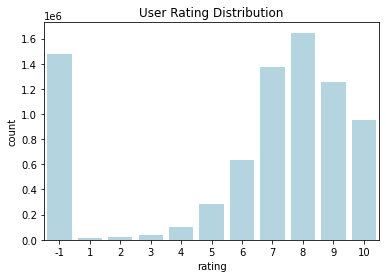

count    7.813730e+06
mean     6.144028e+00
std      3.727801e+00
min     -1.000000e+00
25%      6.000000e+00
50%      7.000000e+00
75%      9.000000e+00
max      1.000000e+01
Name: rating, dtype: float64


In [5]:
# Raw rating distribution
sns.countplot(user_ratings['rating'],
              color='lightblue').set_title('User Rating Distribution')
plt.show()
print(user_ratings.describe()['rating'])

Inspecting the initial distribution of ratings indicates that a large proportion of users which marked the anime as 'watched' haven't actually provided a rating (as indicated by the `-1` values). The distribution of provided ratings is left/negatively skewed on a 1-10 integer scale.

This is normal behavior for users and results in a sparse distribution of item ratings. We will relabel all `-1` values to `0`.

In [6]:
# Flag missing ratings with 0
user_ratings.loc[user_ratings['rating'] == -1, 'rating'] = 0

### 1.2 Anime Data
The dataset of anime data is comprised of the following information:

- `anime_id` - myanimelist.net's unique id identifying an anime.
- `name` - full name of anime.
- `genre` - comma separated list of genres for the anime.
- `type` - movie, TV, OVA, etc.
- `episodes` - how many episodes in this show.
- `rating` - average rating out of 10.
- `members` - number of community members that are in this anime's "group".

In [7]:
# Load anime data
anime_data_path = os.path.join(root, "data", "anime.csv") 
anime = pd.read_csv(anime_data_path)

# Initial inspection
print(anime.dtypes)
anime.head()

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [8]:
# Check missing value counts
pd.isnull(anime).sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Since there are missing values in some of the columns, they should be cleaned up if we are going to use them as features. We will create two seperate dataframes for the anime information, one with only average rating info, and the other with all features.

In [9]:
# Index null ratings
idx_null_rating = pd.Index(anime['rating']).isnull()

anime = anime.loc[~idx_null_rating]  # Drop null rows from 'rating'
anime.drop_duplicates(inplace=True)  # Drop duplicates
anime.reset_index(inplace=True, drop=True)

# Ratings only
anime_ratings = anime.drop(columns=['genre','type','episodes','members'])

print(pd.isnull(anime_ratings).sum())
anime_ratings.head()

anime_id    0
name        0
rating      0
dtype: int64


,anime_id,name,rating
0,32281,Kimi no Na wa.,9.37
1,5114,Fullmetal Alchemist: Brotherhood,9.26
2,28977,Gintama°,9.25
3,9253,Steins;Gate,9.17
4,9969,Gintama&#039;,9.16


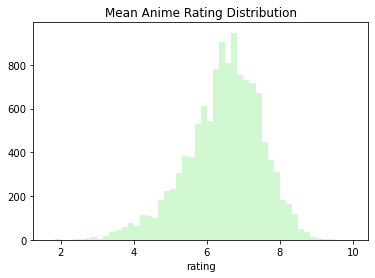

count    12064.000000
mean         6.473902
std          1.026746
min          1.670000
25%          5.880000
50%          6.570000
75%          7.180000
max         10.000000
Name: rating, dtype: float64


In [10]:
sns.distplot(anime_ratings['rating'],
             color='lightgreen',
             kde=False).set_title('Mean Anime Rating Distribution')
plt.show()
print(anime_ratings.describe()['rating'])

The distribution of mean anime ratings appears to be normal with a mean of 6.5 and a std dev of 1.0. This agrees with the central limit theorem.

In [11]:
# Index null genres
idx_null_genre = pd.Index(anime['genre']).isnull()
anime_allfeatures = anime.loc[~idx_null_genre]  # Drop null rows from 'genre'


print(pd.isnull(anime_allfeatures).sum())
anime_allfeatures.head()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [12]:
### Cleaning 'episodes' column
# Drop rows with 'Unknown' 
idx_ep_unknown = (anime_allfeatures['episodes'] == 'Unknown')
anime_allfeatures = anime_allfeatures.loc[~idx_ep_unknown]

# To numeric
anime_allfeatures = anime_allfeatures.astype(dtype={'episodes':'int64'})

anime_allfeatures.reset_index(inplace=True, drop=True)

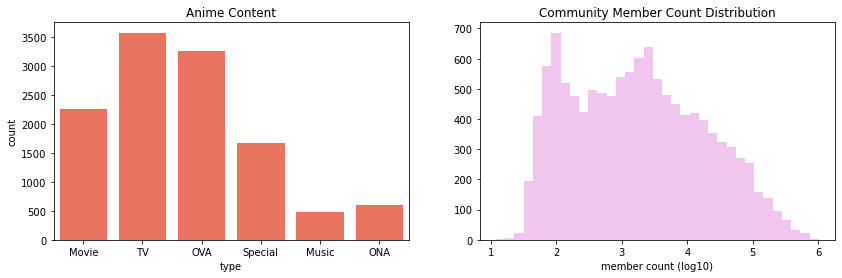

In [13]:
fig, axes = plt.subplots(1,2, figsize=(14,4))

# Plot type counts
sns.countplot(anime_allfeatures['type'],
              color='tomato',
              ax=axes[0]).set_title('Anime Content')



# Visualize Member distribution (log count)
sns.distplot(np.log10(anime_allfeatures['members'].rename('member count (log10)')),
             color='orchid',
             kde=False,
             ax=axes[1]).set_title('Community Member Count Distribution')

plt.show()


In order to process categorical features `genre` and `type`, we need to encode them numerically. We will do so by hot-encoding the categories into binary-valued columns.

In [14]:
## One hot-encode 'type'
anime_allfeatures = pd.get_dummies(anime_allfeatures,
                                   columns=['type'])

# Convert col from str to list
anime_allfeatures['genre'] = anime_allfeatures['genre'].str.split(', ')

# Binarize 'genre'
mlb = MultiLabelBinarizer()
genre_binarized = mlb.fit_transform(anime_allfeatures['genre'])
genre_binarized = pd.DataFrame(genre_binarized, 
                               columns=mlb.classes_,
                               index=anime_allfeatures.index)

# Join result to features df
anime_allfeatures = anime_allfeatures.join(genre_binarized, how='left')
anime_allfeatures.head()

,anime_id,name,genre,episodes,rating,members,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,Martial Arts,Mecha,Military,Music,Mystery,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,Shoujo Ai,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",1,9.37,200630,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",64,9.26,793665,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ...",51,9.25,114262,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",24,9.17,673572,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ...",51,9.16,151266,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


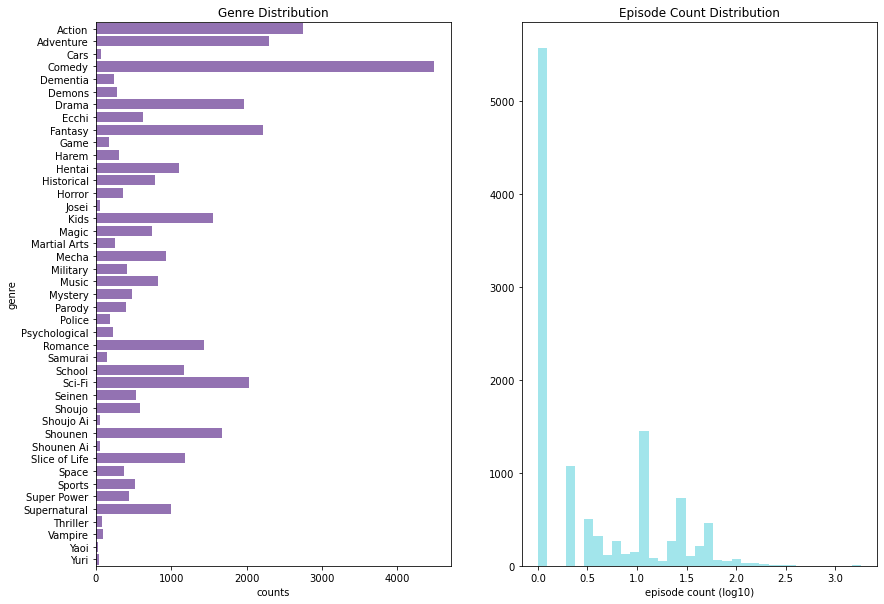

In [15]:
# Visualize Genre distribution
genre_counts = genre_binarized.sum()
genre_counts = genre_counts.to_frame(name='counts').reset_index()
genre_counts = genre_counts.rename(columns={'index':'genre'})

fig, axes = plt.subplots(1,2, figsize=(14,10))

# Plot type counts
sns.barplot(
    y='genre',
    x='counts',
    data=genre_counts,
    color='tab:purple',
    ax=axes[0]
).set_title('Genre Distribution')


# Visualize 'episodes' distribution
sns.distplot(np.log10(anime_allfeatures['episodes'].rename('episode count (log10)')),
             color='tab:cyan',
             kde=False,
             ax=axes[1]).set_title('Episode Count Distribution')

plt.show()

It is obvious that a large portion of anime is have *comedic* elements to them. Other popular genres include *Action*, *Adventure*, and *Fantasy*.

Scaling the distribution of episode by log10, reveals that most of the anime series have less than 10 episodes associated with them likely because movies, and OVAs are included in the data. A good portion of anime have more than 10 episodes, with a few of them having more than 50 episodes.

The episode counts can thus be binned into categorical features as a rough indicator of the length of the series:
- **few**: less than 10 episodes
- **moderate**: 10 to 50 episodes
- **many**: more than 50 episodes

Reducing the granularity of episode counts will allow for more descriptive features.

In [16]:
# One-hot encode categorical 'episodes' 
def categorize_episodes(episodes_col):
    if episodes_col < 10:
        return 'few'
    elif episodes_col <=50:
        return 'moderate'
    else:
        return 'many'

anime_allfeatures['episodes_category'] = anime_allfeatures['episodes'].apply(categorize_episodes)
anime_allfeatures = pd.get_dummies(anime_allfeatures,
                                   columns=['episodes_category'],
                                   prefix='episodes')


We will employ a similar strategy for categorizing and encoding the `members` feature since its distribution is quite sparse. The distribution will be categorized into 5 quantiles of (approximately) equal sizes:
- **1st quantile**: 0-20% of distribution
- **2nd quantile**: 20-40% of distribution
- **3rd quantile**: 40-60% of distribution
- **4th quantile**: 60-80% of distribution
- **5th quantile**: 60-100% of distribution

In [17]:
# Get 'members' quintile values
member_quantiles = [0.2, 0.4, 0.6, 0.8, 1.0]
quintile_names = ['Q1','Q2','Q3','Q4','Q5']

member_quant_vals = anime_allfeatures['members'].quantile(member_quantiles,
                                                          interpolation='nearest').values

print('`members` Quintile values:', list(member_quant_vals))

member_q_val_map = {}
for i in range(len(member_quant_vals)):
    member_q_val_map[member_quant_vals[i]] = quintile_names[i]

# Apply member categories
def categorize_members(members_col):
    for q_val in member_quant_vals:
        if members_col <= q_val:
            return member_q_val_map[q_val]

anime_allfeatures['members_quintile'] = anime_allfeatures['members'].apply(categorize_members)   

# One-hot encode 'members' (binned into quintiles)
anime_allfeatures = pd.get_dummies(anime_allfeatures,
                                   columns=['members_quintile'],
                                   prefix='members')

anime_allfeatures.head()

`members` Quintile values: [155, 794, 2946, 15616, 1013917]


,anime_id,name,genre,episodes,rating,members,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,Martial Arts,Mecha,Military,Music,Mystery,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,Shoujo Ai,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,episodes_few,episodes_many,episodes_moderate,members_Q1,members_Q2,members_Q3,members_Q4,members_Q5
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",1,9.37,200630,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",64,9.26,793665,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ...",51,9.25,114262,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",24,9.17,673572,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ...",51,9.16,151266,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


## 2.0 Baseline Recommender
A simple, often hard to beat baseline recommender is one which always recommends the most popular items which the user has not yet seen. We will use this naive popularity recommender to compare the relative performance of other more complex recommomender systems.

In [18]:
# Map anime_id to name & genre
map_name_genre = anime[['anime_id','name','genre']] \
.set_index('anime_id', verify_integrity=True) \
.sort_index() \
.transpose().to_dict('index')

# Rank popularity of each anime(id) chronologically
popular_rank = user_ratings['anime_id'].value_counts().index


# class popularRecommender:
#     __init__(self  , ):
        